# **Time-series Gnerative Adversarial Networks**



### **Part I: Synthetic Data Generation using TimeGANs**

In [106]:
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from pathlib import Path
from tqdm import tqdm

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import LSTM, GRU, Dense, Input
from keras.losses import BinaryCrossentropy, MeanSquaredError, MeanAbsoluteError

from keras.optimizers import Adam
from keras.metrics import AUC
from sklearn.preprocessing import MinMaxScaler


import yfinance as yf

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [124]:
sns.set_style('white')

#### **Setting Paths and Importing Data**

In [5]:
results_dir = Path('results')

In [6]:
run = 0

In [7]:
log = results_dir / f'run_{run:02}'
if not log.exists():
    log.mkdir(parents=True)

In [8]:
hdf = results_dir / 'TimeSeriesGAN.h5'


In [9]:
time_steps = 24
sequences = 6
batch_size = 128

In [10]:
tickers = ['IBM', 'AAPL', 'NVDA', 'GOOG', 'AMZN', 'MSFT']

In [11]:
end = dt.datetime.today()
start = end - relativedelta(years = 20)

In [13]:
df = yf.download(tickers, start = start, end = end)['Close']

[*********************100%%**********************]  6 of 6 completed


In [14]:
df = pd.DataFrame(df)

In [15]:
df = df.dropna(how = 'any')

In [16]:
df.to_hdf(hdf, 'data/real')

#### **Data Visualisation**

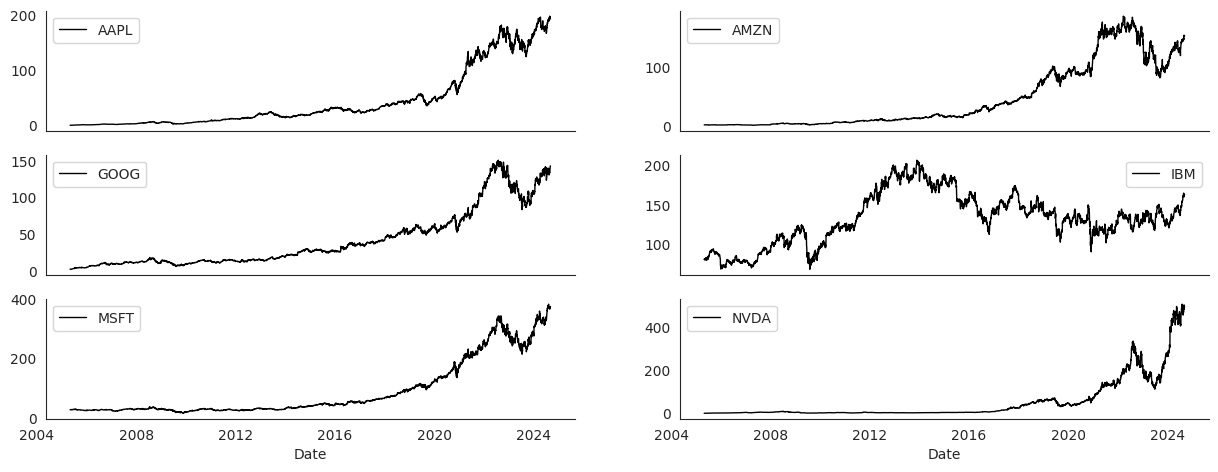

In [126]:
df.plot(subplots = True, figsize = (15, 6), layout = (3, 2), color = 'black', lw = 1, rot=0)
sns.despine()

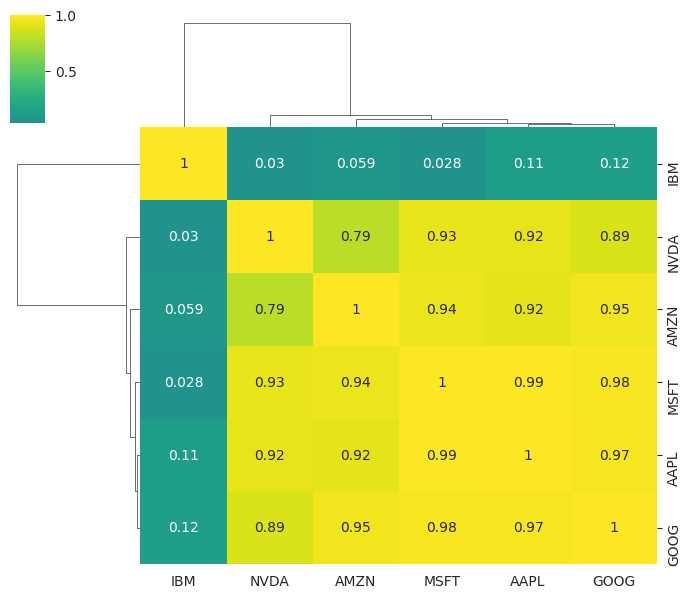

In [127]:
sns.clustermap(df.corr(), annot = True, figsize = (7, 6), cmap = 'viridis', center=0)

#### **Data Processing**

In [19]:
sc = MinMaxScaler()
scaled_data = sc.fit_transform(df).astype(np.float32)

In [20]:
inventory = []
for i in range(len(df) - time_steps):
    inventory.append(scaled_data[i:i + time_steps])

n_windows = len(inventory)

In [21]:
real_series = (tf.data.Dataset.from_tensor_slices(inventory).shuffle(buffer_size=n_windows).batch(batch_size))
real_series_iter = iter(real_series.repeat())

In [22]:
def gen_random():
    while True:
        yield np.random.uniform(low=0, high=1, size=(time_steps, sequences))

In [23]:
random_series = iter(tf.data.Dataset.from_generator(gen_random, output_types=tf.float32).batch(batch_size).repeat())

#### **TimeGAN Setup**

**Embedding and Recovery**:

Let $\mathcal{H_S}, \mathcal{H_S}$ denote the latent vector spaces corresponding to feature spaces $\mathcal{S, X}$. Then the embedding function $\mathcal{e : S}\times\mathcal{\prod\nolimits_{t}X}\rightarrow\mathcal{H_S\prod\nolimits_{t}H_X}$ takes static and temporal features to their latent codes $h_{\mathcal{S}}, h_{1:T} = \mathcal{e}(s, x_{1:T})$.[$\ldots$] we implement $\mathcal{e}$ via a recurrent network:
$$
h_{\mathcal{S}} = e_{\mathcal{S}}(s), \quad h_t = e_{\mathcal{X}}(h_{\mathcal{S}}, h_{t-1}, x_t)
$$

where $e_{\mathcal{S}}(s) : \mathcal{S} \rightarrow\mathcal{H_S}$ is an embedding network for static features and $e_{\mathcal{X}}: \mathcal{H_S}\times\mathcal{H_X}\times\mathcal{X}\rightarrow\mathcal{H_X}$ a recurrent embedding network for temporal features. In the opposite direction, the recovery function $r : \mathcal{H_{S}}\times\prod\nolimits_{t}\mathcal{H_X}\rightarrow\mathcal{S}\times\prod\nolimits_{t}\mathcal{X}$ takes static and temporal codes back to their feature representations $\tilde{s}, \tilde{x}_{1:T} = r(h_\mathcal{S}, h_{1:T})$. Here we implement $r$ through a feedforward network at each step:
$$
\tilde{s} = r_\mathcal{S}(h_s), \quad \tilde{x}_t = r_\mathcal{X}(h_t)
$$
where $r_\mathcal{S}: \mathcal{H_S} \rightarrow \mathcal{S}$ and $r_\mathcal{X}: \mathcal{H_X}\rightarrow \mathcal{X}$ are recovery networks for static and temporal embeddings.

**Generator and Discriminator**:

Let $\mathcal{Z_S}, \mathcal{Z_X}$ denote vector spaces over which known distributions are defined, and from which random vectors are drawn as input for generating into $\mathcal{H_S}, \mathcal{H_X}$. Then the generating function $g: \mathcal{Z_S}\times\prod\nolimits_{t}\mathcal{Z_X}→\mathcal{H_S}\times\prod\nolimits_{t}\mathcal{H_X}$ takes a tuple of static and temporal random vectors to synthetic latent codes $\hat{h}_\mathcal{S}, \hat{h}_{1:T} = g(z_\mathcal{S}, z_{1:T})$. We implement $g$ through a recurrent network,
$$
\hat{h}_\mathcal{S} = g_\mathcal{S}(z_\mathcal{S}), \quad \hat{h}_t = g_\mathcal{X}(\hat{h}_\mathcal{S}, \hat{h}_{t-1}, z_t)
$$
where $g: \mathcal{Z_S}→\mathcal{H_S}$ is an generator network for static features, and $g_\mathcal{X}: \mathcal{H_S}\times\mathcal{H_X}\times\mathcal{Z_X} → \mathcal{H_X}$ is a recurrent generator for temporal features. Random vector $z_\mathcal{S}$ can be sampled from a distribution of choice, and $z_t$ follows a stochastic process.

The discrimination function $d: \mathcal{H_S}\times\prod\nolimits_{t}\mathcal{H_X}→[0, 1]\times\prod\nolimits_{t}[0, 1]$ receives the static and temporal codes, returning classifications $\tilde{y}_\mathcal{S}, \tilde{y}_{1:T} = d(\tilde{h}_\mathcal{S}, \tilde{h}_{1:T})$.[$\ldots$] we implement $d$ via a bidirectional recurrent network with a feedforward output layer,
$$
\tilde{y}_\mathcal{S} = d_\mathcal{S}(\tilde{h}_\mathcal{S}), \quad \tilde{y}_t = d_\mathcal{X}(\overleftarrow{u}_t, \vec{u}_t)
$$
where $\vec{u}_t = \vec{c}_\mathcal{X}(\tilde{h}_\mathcal{S}, \tilde{h}_t, \vec{u}_{t-1})$ and $\overleftarrow{u}_t = \overleftarrow{c}_\mathcal{X}(\tilde{h}_\mathcal{S}, \tilde{h}_t, \overleftarrow{u}_{t+1})$  respectively denote the sequences of forward and backward hidden states, $\vec{c}_\mathcal{X}, \overleftarrow{c}_\mathcal{X}$ are recurrent functions and $d_\mathcal{S}, d_\mathcal{X}$ are output layer classification functions.





In [24]:
writer = tf.summary.create_file_writer(log.as_posix())

In [25]:
X = Input(shape=[time_steps, sequences])
Z = Input(shape=[time_steps, sequences])

In [26]:
def neural_network(num_layers, hidden_units, output, network = 'GRU'):
  if network == 'GRU':
    for i in range(num_layers):
      model = Sequential([GRU(units = hidden_units, return_sequences=True, name = f'GRU_{i + 1}')] +
                              [Dense(units = output, activation = 'sigmoid', name = 'Output')])
    else:
      for i in range(num_layers):
        model = Sequential([LSTM(units=hidden_units, return_sequences=True, name = f'LSTM_{i + 1}')] +
                              [Dense(units = output, activation = 'sigmoid', name = 'Output')])
    return model

In [27]:
embedder = neural_network(num_layers = 3, hidden_units = 24, output = 24)
recovery = neural_network(num_layers = 3, hidden_units = 24, output = 6)
generator = neural_network(num_layers = 3, hidden_units = 24, output = 24)
discriminator = neural_network(num_layers=3, hidden_units = 24, output = 1)
supervisor = neural_network(num_layers = 2, hidden_units = 24, output = 24)

In [28]:
train_steps = 10000
gamma = 1

In [29]:
mse = MeanSquaredError()
bce = BinaryCrossentropy()

In [30]:
autoencoder_optimizer = Adam()
supervisor_optimizer = Adam()
generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedding_optimizer = Adam()

In [31]:
H = embedder(X)
X_tilde = recovery(H)

autoencoder = Model(inputs = X, outputs = X_tilde)

In [32]:
@tf.function
def autoencoder_train_init(x):
  with tf.GradientTape() as tape:
    x_tilde = autoencoder(x)
    embedding_loss_init = mse(x, x_tilde)
    e_loss_init = 10 * tf.sqrt(embedding_loss_init)

  variables = embedder.trainable_variables + recovery.trainable_variables
  gradients = tape.gradient(e_loss_init, variables)
  autoencoder_optimizer.apply_gradients(zip(gradients, variables))
  return tf.sqrt(embedding_loss_init)

In [33]:
for i in tqdm(range(train_steps)):
  X_next = next(real_series_iter)
  step_e_loss_init = autoencoder_train_init(X_next)
  with writer.as_default():
    tf.summary.scalar('Loss Autoencoder Init', step_e_loss_init, step = i)

100%|██████████| 10000/10000 [01:32<00:00, 108.24it/s]


In [34]:
@tf.function
def supervisor_train(x):
  with tf.GradientTape() as tape:
    h = embedder(x)
    h_hat_sup = supervisor(h)
    g_loss_s = mse(h[:, 1:, :], h_hat_sup[:, :-1, :])

    variables = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, variables)
    supervisor_optimizer.apply_gradients(zip(gradients, variables))
    return g_loss_s

In [35]:
for i in tqdm(range(train_steps)):
  X_next = next(real_series_iter)
  step_g_loss_s = supervisor_train(X_next)
  with writer.as_default():
    tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step = i)

100%|██████████| 10000/10000 [01:03<00:00, 158.36it/s]


In [36]:
E_hat = generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

adversarial_sup = Model(inputs = Z, outputs = Y_fake)

In [37]:
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs = Z, outputs = Y_fake_e)

In [38]:
X_hat = recovery(H_hat)
synthetic_data = Model(inputs = Z, outputs = X_hat)

In [39]:
def ret_gen_mom_loss(y, y_hat):
  y_mean, y_var = tf.nn.moments(x = y, axes=[0])
  y_hat_mean, y_hat_var = tf.nn.moments(x=y_hat, axes=[0])
  g_loss_mean = tf.reduce_mean(tf.abs(y_mean - y_hat_mean))
  g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_var + 1e-6) - tf.sqrt(y_hat_var + 1e-6)))
  return g_loss_mean + g_loss_var

In [40]:
Y_real = discriminator(H)
discriminator_model = Model(inputs = X,outputs = Y_real)

In [41]:
@tf.function
def generator_train(x, z):
  with tf.GradientTape() as tape:
    y_fake = adversarial_sup(z)
    gen_loss_unsup = bce(y_true = tf.ones_like(y_fake), y_pred = y_fake)

    y_fake_e = adversarial_emb(z)
    gen_loss_unsup_e = bce(y_true = tf.ones_like(y_fake_e), y_pred = y_fake_e)
    h = embedder(x)
    h_hat_sup = supervisor(h)
    gen_loss_sup = mse(h[:, 1:, :], h_hat_sup[:, 1:, :])
    x_hat = synthetic_data(z)
    gen_mom_loss = ret_gen_mom_loss(x, x_hat)

    gen_loss = (gen_loss_unsup + gen_loss_unsup_e + 100 * tf.sqrt(gen_loss_sup) + 100 * gen_mom_loss)

  variables = generator.trainable_variables + supervisor.trainable_variables
  gradients = tape.gradient(gen_loss, variables)
  generator_optimizer.apply_gradients(zip(gradients, variables))
  return gen_loss_unsup, gen_loss_sup, gen_mom_loss

In [42]:
@tf.function
def embedder_train(x):
  with tf.GradientTape() as tape:
    h = embedder(x)
    h_hat_sup = supervisor(h)
    gen_loss_sup = mse(h[:, 1:, :], h_hat_sup[:, 1:, :])
    x_tilde = autoencoder(x)
    embedding_loss_init = mse(x, x_tilde)
    e_loss = 10 * tf.sqrt(embedding_loss_init) + 0.1 * gen_loss_sup

  variables = embedder.trainable_variables + recovery.trainable_variables
  gradients = tape.gradient(e_loss, variables)
  embedding_optimizer.apply_gradients(zip(gradients, variables))
  return tf.sqrt(embedding_loss_init)

In [43]:
@tf.function
def ret_disc_loss(x, z):
  y_real = discriminator_model(x)
  disc_loss_real = bce(y_true = tf.ones_like(y_real), y_pred = y_real)
  y_fake = adversarial_sup(z)
  disc_loss_fake = bce(y_true = tf.zeros_like(y_fake), y_pred = y_fake)
  y_fake_e = adversarial_emb(z)
  disc_loss_fake_e = bce(y_true = tf.zeros_like(y_fake_e), y_pred=y_fake_e)
  return (disc_loss_real + disc_loss_fake + gamma * disc_loss_fake_e)

In [44]:
@tf.function
def discriminator_train(x, z):
  with tf.GradientTape() as tape:
    disc_loss = ret_disc_loss(x, z)

  variables = discriminator.trainable_variables
  gradients = tape.gradient(disc_loss, variables)
  discriminator_optimizer.apply_gradients(zip(gradients, variables))
  return disc_loss

In [45]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for i in range(train_steps):
  for j in range(2):
    X_next = next(real_series_iter)
    Z_next = next(random_series)
    step_g_loss_u, step_g_loss_s, step_g_loss_v = generator_train(X_next, Z_next)
    step_e_loss_init = embedder_train(X_next)

  X_next = next(real_series_iter)
  Z_next = next(random_series)
  step_d_loss = ret_disc_loss(X_next, Z_next)
  if step_d_loss > 0.15:
    step_d_loss = discriminator_train(X_next, Z_next)

  if i % 1000 == 0:
    print(f'{i:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
      f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')

  with writer.as_default():
    tf.summary.scalar('G Loss S', step_g_loss_s, step = i)
    tf.summary.scalar('G Loss U', step_g_loss_u, step = i)
    tf.summary.scalar('G Loss V', step_g_loss_v, step = i)
    tf.summary.scalar('E Loss T0', step_e_loss_t0, step = i)
    tf.summary.scalar('D Loss', step_d_loss, step = i)

     0 | d_loss: 1.9817 | g_loss_u: 0.8219 | g_loss_s: 0.0003 | g_loss_v: 0.3558 | e_loss_t0: 0.0000
 1,000 | d_loss: 0.6104 | g_loss_u: 2.9236 | g_loss_s: 0.0002 | g_loss_v: 0.0456 | e_loss_t0: 0.0000
 2,000 | d_loss: 0.7001 | g_loss_u: 3.0317 | g_loss_s: 0.0003 | g_loss_v: 0.1212 | e_loss_t0: 0.0000
 3,000 | d_loss: 1.0871 | g_loss_u: 2.6130 | g_loss_s: 0.0003 | g_loss_v: 0.0469 | e_loss_t0: 0.0000
 4,000 | d_loss: 0.9943 | g_loss_u: 3.3411 | g_loss_s: 0.0002 | g_loss_v: 0.0718 | e_loss_t0: 0.0000
 5,000 | d_loss: 0.9675 | g_loss_u: 2.7124 | g_loss_s: 0.0002 | g_loss_v: 0.0591 | e_loss_t0: 0.0000
 6,000 | d_loss: 1.1426 | g_loss_u: 1.7763 | g_loss_s: 0.0002 | g_loss_v: 0.0636 | e_loss_t0: 0.0000
 7,000 | d_loss: 0.9287 | g_loss_u: 1.6206 | g_loss_s: 0.0001 | g_loss_v: 0.1119 | e_loss_t0: 0.0000
 8,000 | d_loss: 0.9282 | g_loss_u: 1.4311 | g_loss_s: 0.0001 | g_loss_v: 0.0412 | e_loss_t0: 0.0000
 9,000 | d_loss: 1.2778 | g_loss_u: 1.0670 | g_loss_s: 0.0002 | g_loss_v: 0.0691 | e_loss_t

In [46]:
synthetic_data.save(log / 'synthetic_data')

In [47]:
new_data = []
for i in range(int(n_windows / batch_size)):
  Z_next = next(random_series)
  r = synthetic_data(Z_next)
  new_data.append(r)

In [48]:
new_data = np.array(np.vstack(new_data))


In [49]:
np.save(log / 'gen_data.npy', new_data)

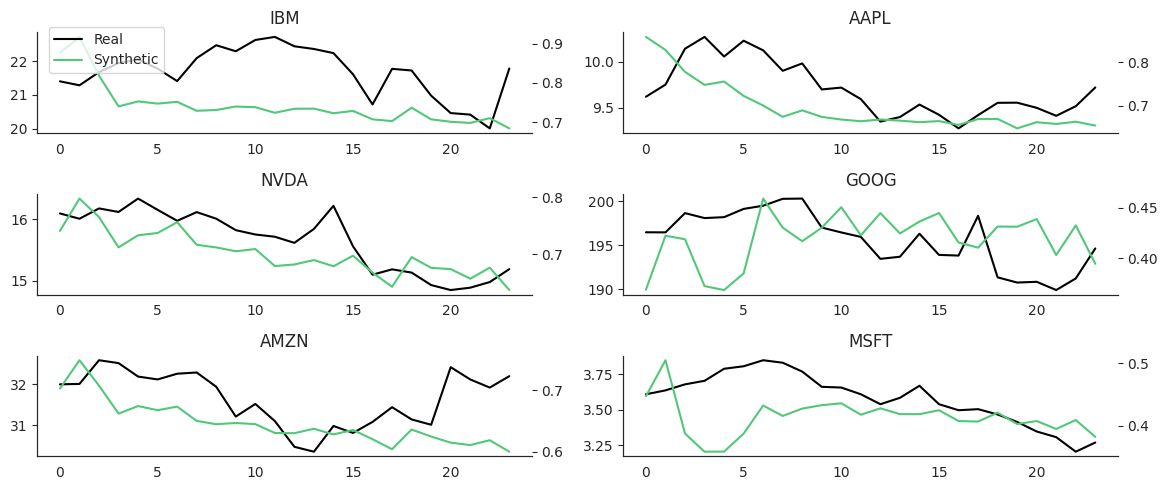

In [136]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 5))
axes = axes.flatten()

index = list(range(1, 25))
syn = new_data[np.random.randint(n_windows)]

idx = np.random.randint(len(df) - time_steps)
real = df.iloc[idx: idx + time_steps]

for i, j in enumerate(tickers):
    (pd.DataFrame({'Real': real.iloc[:, i].values, 'Synthetic': syn[:, i]}).plot(ax=axes[i],
                                                                                 title = j,
                                                                                 secondary_y='Synthetic',
                                                                                 color = ['black', '#50C878'],
                                                                                 lw = 1.5, legend = False))

    sns.despine()

real_legend = Line2D([0], [0], color='black', lw=1.5, label='Real')
synthetic_legend = Line2D([0], [0], color='#50C878', lw=1.5, label='Synthetic')

custom_legend = fig.legend(handles=[real_legend, synthetic_legend], loc='upper left', bbox_to_anchor=(0.05, 0.95))
fig.subplots_adjust(right=0.85)

fig.tight_layout()


### **Part II: Synthetic Data Evaluation**

In [77]:
def ret_real_data():
    df.sort_index()
    sc = MinMaxScaler()
    scaled_data = sc.fit_transform(df)
    inventory = []
    for i in range(len(df) - time_steps):
      inventory.append(scaled_data[i:i + time_steps])
    return inventory
real_data = ret_real_data()

In [78]:
np.asarray(real_data).shape


(4848, 24, 6)

In [79]:
path = Path('results')
synthetic_data = np.load(path / f'run_{run:02d}' / 'gen_data.npy')
synthetic_data.shape

(4736, 24, 6)

In [80]:
real_data = real_data[:synthetic_data.shape[0]]

In [81]:
sample_size = 250
idx = np.random.permutation(len(real_data))[:sample_size]

In [82]:
real_sample = np.asarray(real_data)[idx]
synthetic_sample = np.asarray(synthetic_data)[idx]

In [83]:
real_sample_2d = real_sample.reshape(-1, sequences)
synthetic_sample_2d = synthetic_sample.reshape(-1, sequences)

#### **Assessing Diversity**

In [84]:
pca = PCA(n_components=2)
pca.fit(real_sample_2d)
pca_real = (pd.DataFrame(pca.transform(real_sample_2d))
            .assign(Data='Real'))
pca_synthetic = (pd.DataFrame(pca.transform(synthetic_sample_2d))
                 .assign(Data='Synthetic'))
pca_result = pca_real.append(pca_synthetic).rename(
    columns={0: '1st Component', 1: '2nd Component'})

In [145]:
tsne_data = np.concatenate((real_sample_2d,
                            synthetic_sample_2d), axis=0)

tsne = TSNE(n_components=2,
            verbose=1,
            perplexity=40)
tsne_result = tsne.fit_transform(tsne_data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 12000 samples in 0.012s...
[t-SNE] Computed neighbors for 12000 samples in 0.348s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12000
[t-SNE] Computed conditional probabilities for sample 2000 / 12000
[t-SNE] Computed conditional probabilities for sample 3000 / 12000
[t-SNE] Computed conditional probabilities for sample 4000 / 12000
[t-SNE] Computed conditional probabilities for sample 5000 / 12000
[t-SNE] Computed conditional probabilities for sample 6000 / 12000
[t-SNE] Computed conditional probabilities for sample 7000 / 12000
[t-SNE] Computed conditional probabilities for sample 8000 / 12000
[t-SNE] Computed conditional probabilities for sample 9000 / 12000
[t-SNE] Computed conditional probabilities for sample 10000 / 12000
[t-SNE] Computed conditional probabilities for sample 11000 / 12000
[t-SNE] Computed conditional probabilities for sample 12000 / 12000
[t-SNE] Mean sigma: 0.004600
[t-SNE] KL divergenc

In [146]:
tsne_result = pd.DataFrame(tsne_result, columns=['1st dim', '2nd dim']).assign(Data='Real')
tsne_result.loc[sample_size*6:, 'Data'] = 'Synthetic'

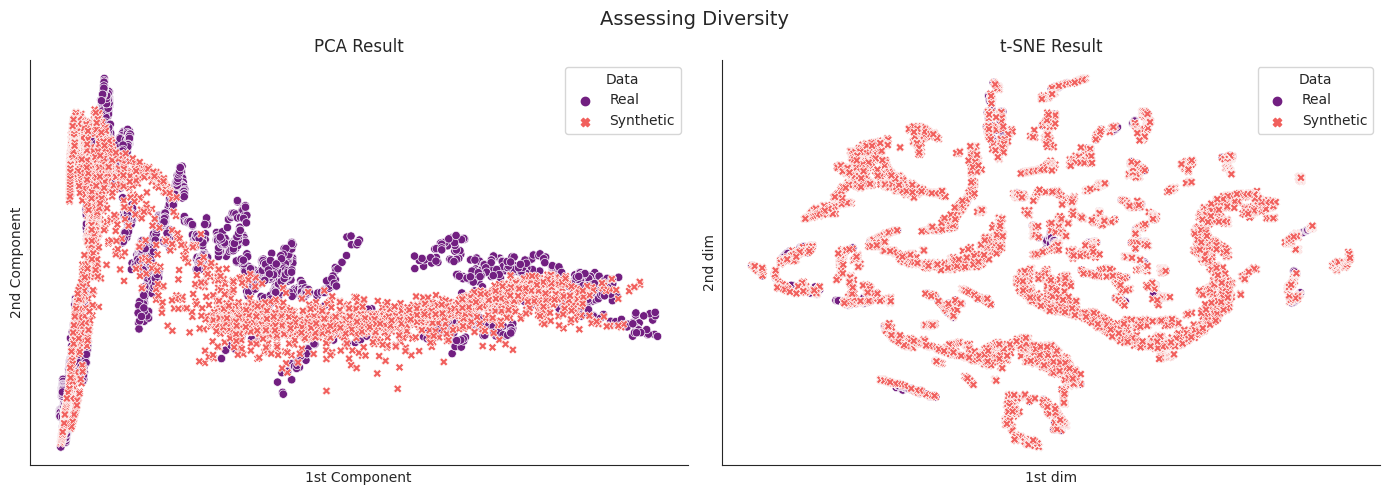

In [147]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.scatterplot(x='1st Component', y='2nd Component', data=pca_result, hue='Data', style='Data',
                ax=axes[0], palette= 'magma')
sns.despine()
axes[0].set_title('PCA Result')


sns.scatterplot(x='1st dim', y='2nd dim', data=tsne_result, hue='Data', style='Data', ax=axes[1], palette= 'magma')
sns.despine()
for i in [0, 1]:
    axes[i].set_xticks([])
    axes[i].set_yticks([])

axes[1].set_title('t-SNE Result')
fig.suptitle('Assessing Diversity',
             fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.88)

#### **Assessing Fidelity**

In [88]:
real_data = ret_real_data()
real_data = np.array(real_data)[:len(synthetic_data)]

In [89]:
index = np.arange(real_data.shape[0])

In [90]:
split_train = int(.8 * real_data.shape[0])
train_index = index[:split_train]
test_index = index[split_train:]

In [91]:
train_series = np.vstack((real_data[train_index], synthetic_data[train_index]))
test_series = np.vstack((real_data[test_index], synthetic_data[test_index]))

In [93]:
split_train, split_test = len(train_index), len(test_index)
train_labels = np.concatenate((np.ones(split_train), np.zeros(split_train)))
test_labels = np.concatenate((np.ones(split_test), np.zeros(split_test)))

In [92]:
classifier = Sequential([GRU(6, input_shape=(24, 6)), Dense(1, activation='sigmoid')])

In [95]:
classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=[AUC(name='AUC'), 'accuracy'])

In [96]:
classifier_fit = classifier.fit(x = train_series, y = train_labels, validation_data = (test_series, test_labels),
                                epochs=250,
                                batch_size=128,
                                verbose=0)

In [97]:
classifier.evaluate(x = test_series, y = test_labels)

60/60 [==============================] - 1s 9ms/step - loss: 4.9575 - AUC: 0.4942 - accuracy: 0.5638


[4.95750617980957, 0.4941576421260834, 0.5638185739517212]

In [98]:
history = pd.DataFrame(classifier_fit.history)

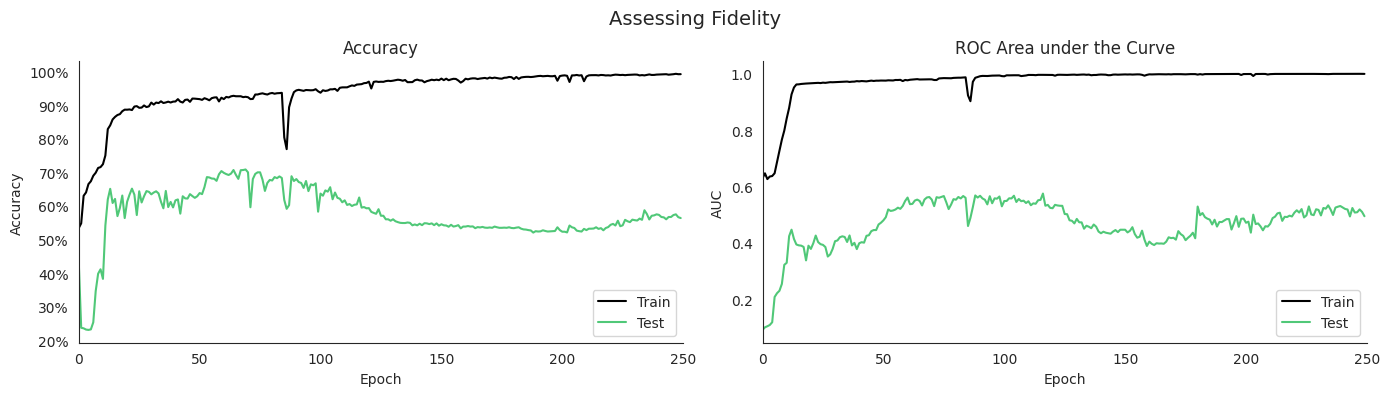

In [134]:
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
history[['AUC', 'val_AUC']].rename(columns={'AUC': 'Train', 'val_AUC': 'Test'}).plot(ax=axes[1],
                                                                                     title='ROC Area under the Curve',
                                                                                     color=['black', '#50C878'],
                                                                                     xlim=(0, 250))
history[['accuracy', 'val_accuracy']].rename(columns={'accuracy': 'Train', 'val_accuracy': 'Test'}).plot(ax=axes[0],
                                                                                                         title='Accuracy',
                                                                                                         color=['black', '#50C878'],
                                                                                                         xlim=(0, 250))
for i in [0, 1]:
    axes[i].set_xlabel('Epoch')

axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[0].set_ylabel('Accuracy')
axes[1].set_ylabel('AUC')
sns.despine()
fig.suptitle('Assessing Fidelity', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85)

#### **Assessing Usefulness**

In [116]:
real_data = ret_real_data()
real_data = np.array(real_data)[:len(synthetic_data)]

In [117]:
train_rd = real_data[train_index, :23, :]
train_rl= real_data[train_index, -1, :]

test_rd= real_data[test_index, :23, :]
test_rl = real_data[test_index, -1, :]

In [118]:
synthetic_train = synthetic_data[:, :23, :]
synthetic_label = synthetic_data[:, -1, :]

In [119]:
def ret_model():
  model = Sequential([GRU(12, input_shape = (time_steps -1, sequences)), Dense(6)])
  model.compile(optimizer = Adam(), loss = MeanAbsoluteError())
  return model

In [120]:
reg = ret_model()
syn_res = reg.fit(x = synthetic_train, y = synthetic_label, validation_data = (test_rd, test_rl),
                           epochs=100,
                           batch_size=128,
                           verbose=0)

In [121]:
real_res = reg.fit(x = train_rd, y = train_rl, validation_data=(test_rd, test_rl), epochs=100,
                   batch_size=128,
                   verbose=0)

In [122]:
syn_res = pd.DataFrame(syn_res.history).rename(columns={'loss': 'Train', 'val_loss': 'Test'})
real_res = pd.DataFrame(real_res.history).rename(columns={'loss': 'Train', 'val_loss': 'Test'})

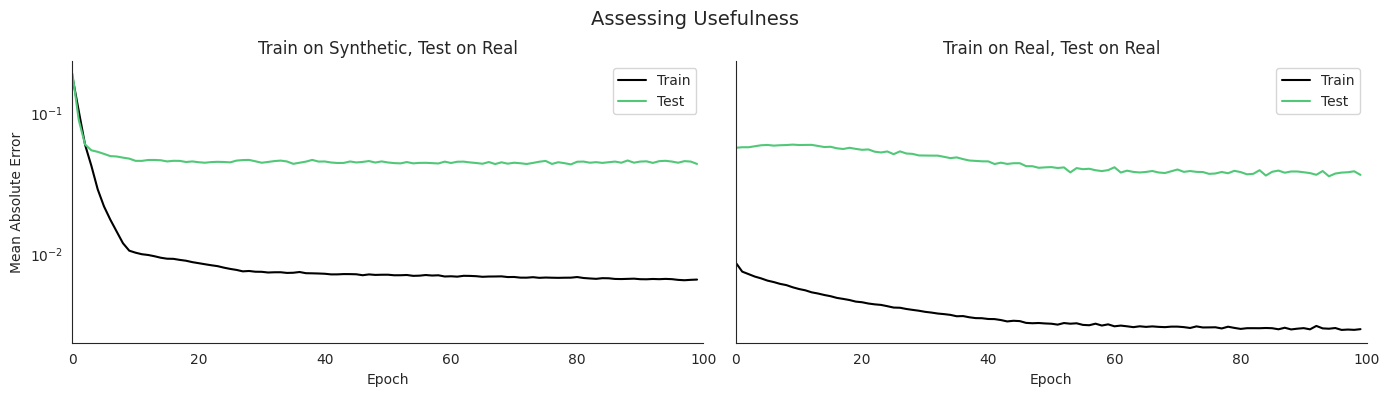

In [135]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)
syn_res.plot(ax=axes[0], title='Train on Synthetic, Test on Real', color=['black', '#50C878'],
                      logy=True, xlim=(0, 100))
real_res.plot(ax=axes[1], title='Train on Real, Test on Real', color=['black', '#50C878'],
                 logy=True, xlim=(0, 100))
for i in [0, 1]:
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Mean Absolute Error')

sns.despine()
fig.suptitle('Assessing Usefulness', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85)